In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

del pmap['ggF-powheg']
del pmap['muondata']

In [3]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.2

year='2017'

In [4]:
indir = "../outfiles/notrigger/chunksize100000_noSF/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
outsum = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)

started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum['templates'] = out['templates']
            outsum['sumw'] = out['sumw']
            started += 1
        else:
            outsum['templates'].add(out['templates'])
            outsum['sumw'].add(out['sumw'])
    
        del out

Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_data.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_higgs.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_qcd.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_top.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_wandvv.coffea
Loading ../outfiles/notrigger/chunksize100000_noSF/2017_dask_z.coffea


In [5]:
scale_lumi = {k: xs[k] * 1000 * lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates'].scale(scale_lumi, 'dataset')

templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

In [11]:
h = templates.integrate('region','signal').sum('genflavor', 'pt1').integrate('ddb1',int_range=slice(0.64,1))
h_data = templates['data'].integrate('region','signal').sum('genflavor', 'pt1').integrate('ddb1',int_range=slice(0.64,1))

<AxesSubplot:xlabel='Jet $m_{sd}$', ylabel='Events'>

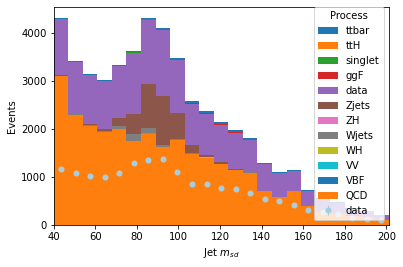

In [7]:
data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#a6cee3',
            'elinewidth': 1,
        }
        
fig, ax = plt.subplots(1, 1)
hist.plot1d(h,
        stack="process",
        ax=ax)

hist.plot1d(h_data,
        overlay="process",
        ax=ax,
        error_opts=data_err_opts,
        clear=False)

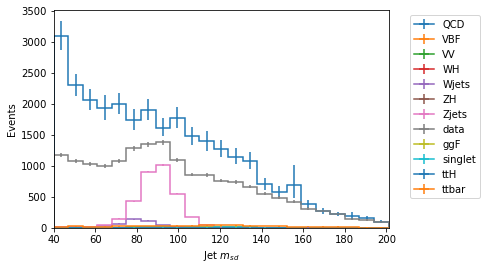

In [12]:
hist.plot1d(h,overlay='process')
plt.legend(bbox_to_anchor=(1.05,1))

<AxesSubplot:xlabel='Jet $m_{sd}$', ylabel='Events'>

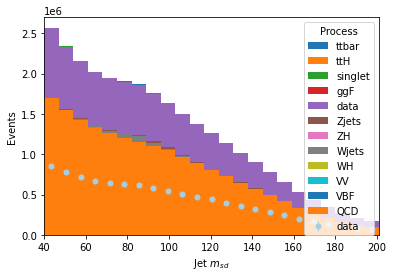

In [9]:
data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#a6cee3',
            'elinewidth': 1,
        }
        
fig, ax = plt.subplots(1, 1)
hist.plot1d(h,
        stack="process",
        ax=ax)

hist.plot1d(h_data,
        overlay="process",
        ax=ax,
        error_opts=data_err_opts,
        clear=False)

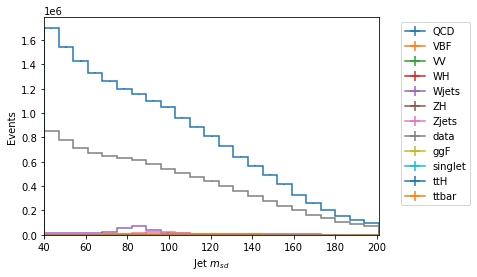

In [10]:
hist.plot1d(h,overlay='process')
plt.legend(bbox_to_anchor=(1.05,1))

In [9]:
processes = [t[0] for t in templates.values().keys() if t[1] == 'signal']
processes

['ZH',
 'WH',
 'ttH',
 'VBF',
 'ggF',
 'QCD',
 'VV',
 'Wjets',
 'Zjets',
 'ttbar',
 'singlet',
 'data']

In [ ]:
pt = 350
fout = uproot3.create('../pt{0}/signalregion_pt{0}.root'.format(pt))
for ddb_region in ['pass', 'fail']:
    if ddb_region == 'pass':
        ddb_l = 0.64
        ddb_r = 1
        ext = "_pass"
    elif ddb_region == 'fail':
        ddb_l = 0
        ddb_r = 0.64
        ext = "_fail"
            
    h = templates.integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
    
    for process in processes:
        print(process, end="")
        fout[process + ext] = hist.export1d(h[process].sum('process'))
        print("...done")
fout.close()

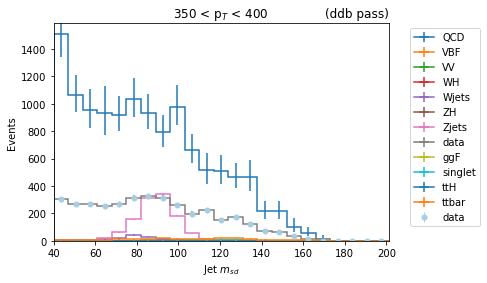

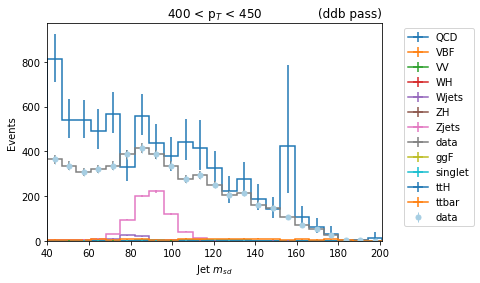

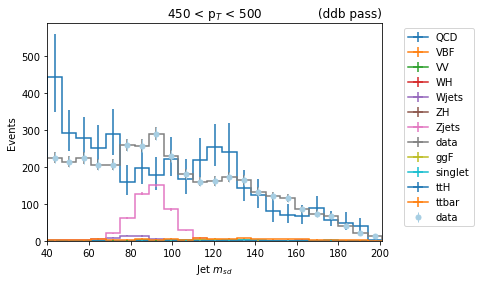

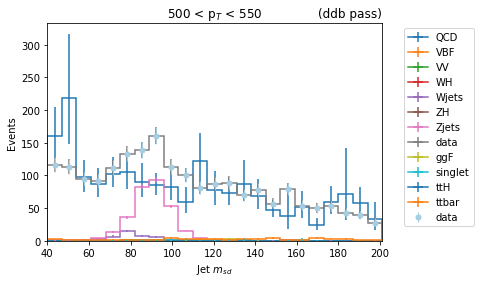

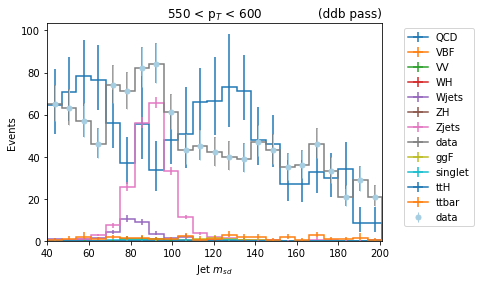

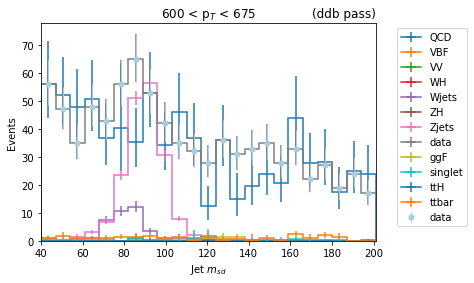

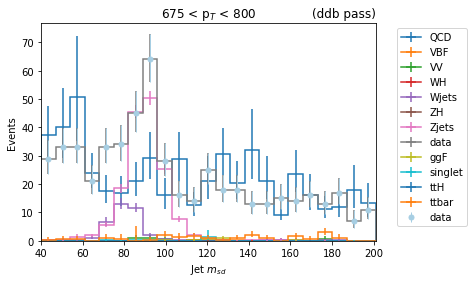

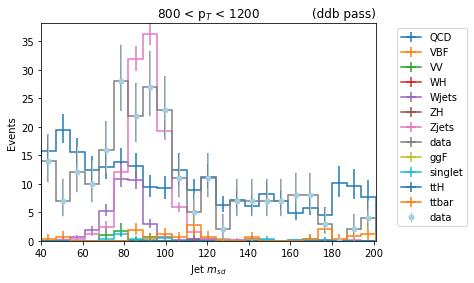

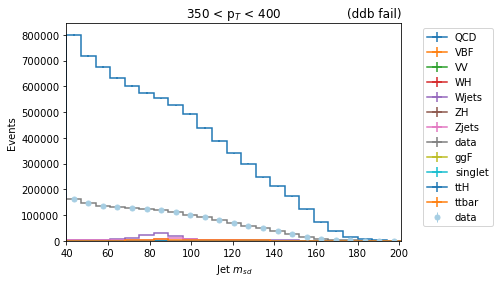

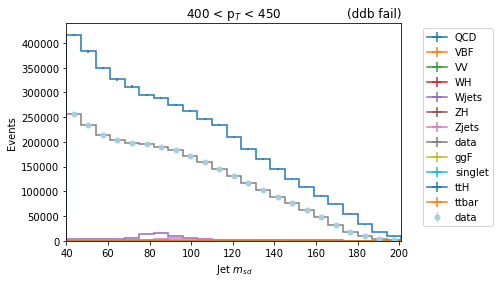

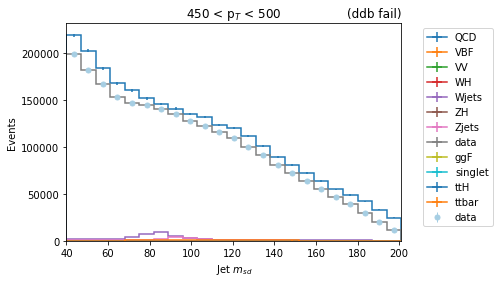

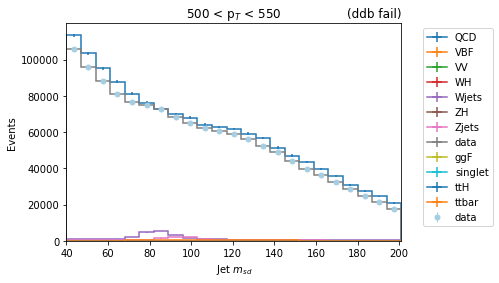

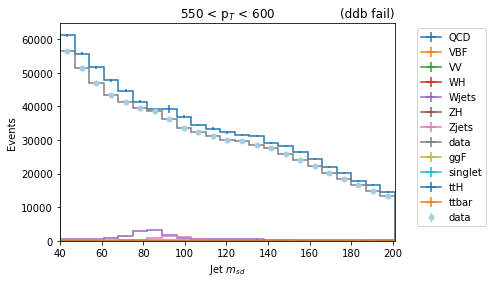

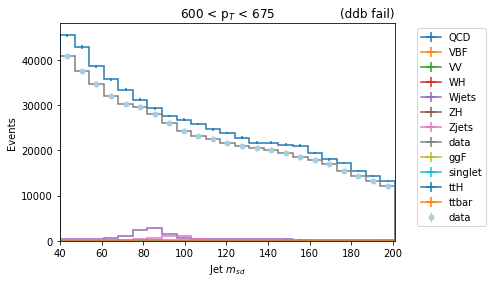

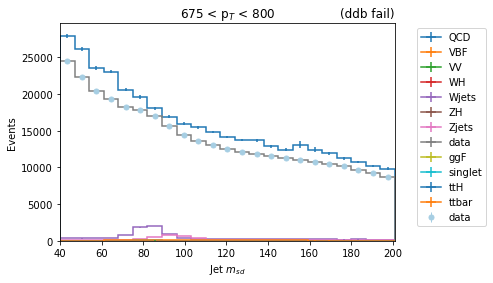

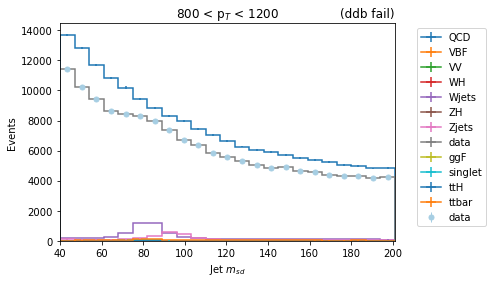

In [13]:
pt_bins = [350, 400, 450, 500, 550, 600, 675, 800, 1200]
#fout = uproot3.create('../pt{0}/signalregion_pt{0}_ptbins.root'.format(pt_bins[0]))
for ddb_region in ['pass', 'fail']:
    for i in range(len(pt_bins)-1):
        if ddb_region == 'pass':
            ddb_l = 0.64
            ddb_r = 1
            ext = "_pass"
        elif ddb_region == 'fail':
            ddb_l = 0
            ddb_r = 0.64
            ext = "_fail"

        ext += "_pt{0}".format(i)

        h = templates.integrate('pt1', slice(pt_bins[i], pt_bins[i+1])).integrate('region','signal').sum('genflavor').integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        h_data = templates['data'].integrate('pt1', slice(pt_bins[i], pt_bins[i+1])).integrate('region','signal').sum('genflavor').integrate('ddb1',int_range=slice(ddb_l,ddb_r))

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#a6cee3',
            'elinewidth': 1,
        }
        
        fig, ax = plt.subplots(1, 1)
        hist.plot1d(h,
                overlay="process",
                ax=ax)
        
        hist.plot1d(h_data,
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts)
        
        ax.legend(bbox_to_anchor=(1.05,1))
        ax.set_title('(ddb {0})'.format(ddb_region), loc='right')
        ax.set_title(r'{0} < p$_T$ < {1}'.format(pt_bins[i], pt_bins[i+1]), loc='center')
        
        #for process in processes:
        #    fout[process + ext] = hist.export1d(h[process].sum('process'))
#fout.close()

In [ ]:
pt_bins = [350, 400, 450, 500, 550, 600, 675, 800, 1200]
#fout = uproot3.create('../pt{0}/signalregion_ptbins.root'.format(pt_bins[0]))
for ddb_region in ['pass']: #, 'fail', 'both']:
    for i in range(len(pt_bins)-1):
        if ddb_region == 'pass':
            ddb_l = 0.64
            ddb_r = 1
            ext = "_pass"
        elif ddb_region == 'fail':
            ddb_l = 0
            ddb_r = 0.64
            ext = "_fail"
        else:
            ddb_l = 0
            ddb_r = 1
            ext = "_both"

        ext += "_pt{0}".format(i)

        h = templates.integrate('pt1', slice(pt_bins[i], pt_bins[i+1])).integrate('region','signal').sum('genflavor').integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        h_data = templates['data'].integrate('pt1', slice(pt_bins[i], pt_bins[i+1])).integrate('region','signal').sum('genflavor').integrate('ddb1',int_range=slice(ddb_l,ddb_r))

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#a6cee3',
            'elinewidth': 1,
        }
        
        fig, ax = plt.subplots(1, 1)
        hist.plot1d(h,
                stack="process",
                ax=ax)
        
        hist.plot1d(h_data,
            overlay="process",
            ax=ax,
            error_opts=data_err_opts,
            clear=False)

        ax.legend(loc='best')#bbox_to_anchor=(1.05,1))
        ax.set_title('(ddb {0})'.format(ddb_region), loc='right')
        ax.set_title(r'{0} < p$_T$ < {1}'.format(pt_bins[i], pt_bins[i+1]), loc='center')
        #fig.savefig('../plots/qcd_ht_distr/selection/all/' + ddb_region + '/pt' + str(pt_bins[i]) + "to" + str(pt_bins[i+1]) + "_" + ddb_region + ".png")
        
        #for process in processes:
            #fout[process + ext] = hist.export1d(h[process].sum('process'))
#fout.close()

In [ ]:
h = templates['QCD_HT300*'].integrate('region','noselection').sum('genflavor', 'msd1').integrate('ddb1',int_range=slice(ddb_l,ddb_r))
hist.plot1d(h, overlay='process')